# Demo 1: Recurrent Neural Networks (RNNs)

RNNs are a type of artificial neural network designed to process sequences of data. They work expecially well for tasks requiring sequences, such as time series data, voice, natural language, and other activities.

This demo we will demo code for construct a RNN model to solve the regression problem:
-   Problem: Predict stock close price of Taiwan Semiconductor Manufacturing Company (TSMC) based on the stock close price of TSMC in previous period
-   Dataset: Stock dataset which is getting from yahoo finance database by using the yfinance package.
-   Library packages:
    -   Yfinance (offers a threaded and Pythonic way to download market data from Yahoo finance)
    -   Pandas (A fast and efficient dataframe object for data manipulation with integrated indexing, reading and writing data between in-memory data structures and different formats: CSV, Microsoft Excel, SQL databases)
    -   Matplotlib (Plot package: visualize data, result,...)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learning (Machine Learning library)

Tasks Outlines:

## 0. Task 0: Preparing dataset
-   Getting the stock dataset of TSMC
-   Exploring about the dataset
-   Normalize or standardlize dataset
-   Divide dataset to trainset and testset
## 1. Task 1: Constructing model by using TensorFlow library:
-   Create a Recurrent Neural Network for regression problem
-   Training model on our trainset and applying the early stopping during the training
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Predict the price of stock
-   Compute the metrics (quantitative measurements)
    -   R2_score, Mean Absolute Error (MAE), Root MAE,...
## 3. Task 3: Performing a rolling regression 

## Import all packages

In [35]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance
from matplotlib import pyplot as plt
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_data_stock_yfinance.ipynb to get detail of demo code for this step

### 0.1. Getting stock data of TSMC with company Code: TSM from 2 years ago.

In [16]:
# Getting stock data of Company Name: TSMC with Company Code: TSM
"""
-   start_date: start time to getting data stock
-   end_data: end time to getting data stock
-   data_source: where to getting data
"""
now = datetime.now()
data_source = 'yahoo'
start_date = now.today() - relativedelta(years  = 2)
end_date = now.today()
print(start_date)
print(end_date)
df_TSM = yfinance.download("TSM",start=start_date,end=end_date)

2021-12-25 17:55:25.599851
2023-12-25 17:55:25.600269
[*********************100%%**********************]  1 of 1 completed


### 0.2. Exploring the data:
See the file Demo_data_stock_yfinance.ipynb for more detail.

In [17]:
# Type of data after getting from yfinance:
print(type(df_TSM))

<class 'pandas.core.frame.DataFrame'>


In [18]:
# Data info:
df_TSM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2021-12-27 to 2023-12-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       502 non-null    float64
 1   High       502 non-null    float64
 2   Low        502 non-null    float64
 3   Close      502 non-null    float64
 4   Adj Close  502 non-null    float64
 5   Volume     502 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


In [19]:
# Showing most recently five days in our dataframe
df_TSM.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-18,102.839996,103.309998,102.080002,102.930000,102.930000,5660600
2023-12-19,103.239998,103.980003,103.089996,103.870003,103.870003,8498500
2023-12-20,102.699997,103.089996,99.940002,100.040001,100.040001,10814100
2023-12-21,101.300003,102.720001,101.160004,102.550003,102.550003,9068200
2023-12-22,102.930000,103.589996,102.709999,103.150002,103.150002,5566400


### 0.3. Visualize data in stock form.

In [20]:
# Preparing data to plot: range of close open, range of low high, check close >= open for each day
df_TSM["Y_price"] = (df_TSM["Open"] + df_TSM["Close"])/2
df_TSM["Y_error"] = (df_TSM["Open"] - df_TSM["Close"]).abs()/2
df_TSM["HL"] = (df_TSM["High"] + df_TSM["Low"])/2
df_TSM["HL_error"] = (df_TSM["High"] - df_TSM["Low"]).abs()/2
df_TSM["IsPositive"] = df_TSM["Close"] >= df_TSM["Open"]

In [21]:
# We only plot most recently 100 days stock data of TSMC:
data_to_plot = df_TSM.tail(100)

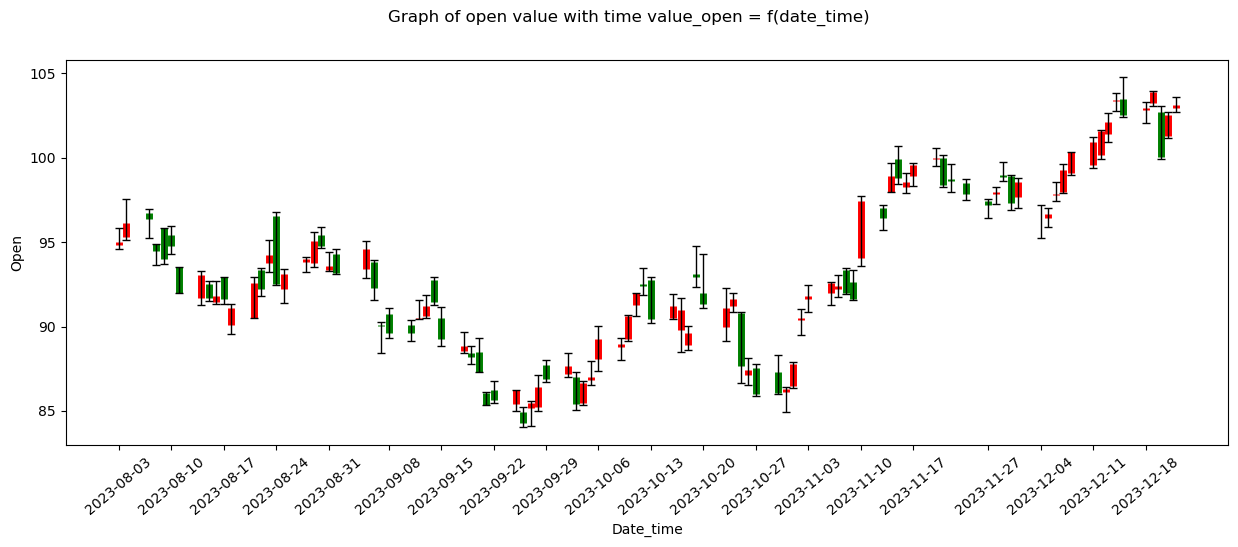

In [22]:
# Visualize data
colors = {True:'red',False:'green'}

fig, ax = plt.subplots(1,1,figsize = (15,5))
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Open"],color='g')
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Close"],color='red')
""" 
The following line of code plot bar range open close, color base on
the comparision of open price and close price
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["Y_price"],
            data_to_plot["Y_error"],
            linewidth = 5, 
            capsize=0,
            ls='none',
            ecolor = data_to_plot['IsPositive'].map(colors))
"""
The following line of code plot black interval with the width = high - low
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["HL"],
            data_to_plot["HL_error"],
            linewidth = 1,
            capsize=3,
            color='k',
            ls='none')

fig.suptitle("Graph of open value with time value_open = f(date_time)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Open")
ax.set_xticks(data_to_plot.index.tolist()[::5]) #Without this it is too dense, with this we only display every after 5 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center
plt.show()

### 0.4. Prepare data for training model:
-   We consider the Close column in our data set as timeseries data
-   Divide data into two parts:
    -   For training: first 400 rows
    -   For testing: start from row 400th
-   Creating a data structure with 60 timesteps and 1 ouput


In [23]:
df_TSM["Close"][:400].values[0:60]

array([122.69999695, 122.05999756, 121.41000366, 120.41999817,
       120.30999756, 128.80000305, 133.3999939 , 127.05999756,
       128.47000122, 123.5       , 125.01000214, 129.16999817,
       132.22999573, 139.19000244, 140.66000366, 133.83000183,
       131.00999451, 128.33000183, 124.52999878, 125.95999908,
       122.48000336, 123.08000183, 116.37999725, 117.61000061,
       122.62999725, 123.05000305, 124.15000153, 119.83999634,
       121.01999664, 122.30999756, 123.70999908, 125.51999664,
       124.70999908, 121.01000214, 119.76999664, 124.51999664,
       123.59999847, 119.76000214, 119.30999756, 116.91000366,
       115.90000153, 111.87999725, 111.23000336, 107.01000214,
       108.05000305, 109.61000061, 108.79000092, 105.05999756,
        99.29000092, 100.        , 104.94999695, 103.95999908,
       101.41000366,  99.30000305, 102.08999634, 105.69000244,
       106.48999786, 106.72000122, 106.91999817, 107.04000092])

In [24]:
train_data = df_TSM["Close"][:400].values
test_data = df_TSM["Close"][400:].values
X_train = []
y_train = []
for i in range(60,400):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i])
X_train,y_train = np.array(X_train),np.array(y_train)
# Reshaping 
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [25]:
X_train.shape

(340, 60, 1)

## 1. Task 1: Constructing model by using TensorFlow library:
### 1.1. Creating Recurrent Neural Network model

RNN with 3 SimpleRNN layers and one output layer


In [26]:
# Define the model CNN
model_RNN = Sequential()
## Adding the first SimpleRNN layer and some Dropout regularisation
model_RNN.add(SimpleRNN(units = 60,
                        return_sequences=True,
                        input_shape = (X_train.shape[1],1)))
model_RNN.add(Dropout(0.2))
## Adding the second SimpleRNN layer and some Dropout regularisation
model_RNN.add(SimpleRNN(units=50,
                        return_sequences=True))
model_RNN.add(Dropout(0.2))
## Adding the third SimpleRNN layer and some Dropout regularisation
model_RNN.add(SimpleRNN(units=50,
                        return_sequences=True))
model_RNN.add(Dropout(0.2))
## Adding the fourth SimpleRNN layer and some Dropout regularisation
model_RNN.add(SimpleRNN(units=50))
model_RNN.add(Dropout(0.2))
## Adding the output layer
model_RNN.add(Dense(units=1))

2023-12-25 17:55:26.877664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 60)            3720      
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 50)            5550      
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

### 1.2. Training model

In [40]:
epochs = 300
optimizer = keras.optimizers.Adam()
model_RNN.compile(optimizer=optimizer,
                  loss='mean_squared_error')
history = model_RNN.fit(X_train,y_train, epochs = 300, batch_size=32)

Epoch 1/300
11/11 [==============================] - 4s 74ms/step - loss: 68.7075
Epoch 2/300
11/11 [==============================] - 1s 63ms/step - loss: 65.8171
Epoch 3/300
11/11 [==============================] - 1s 62ms/step - loss: 74.5114
Epoch 4/300
11/11 [==============================] - 1s 76ms/step - loss: 69.2988
Epoch 5/300
11/11 [==============================] - 1s 88ms/step - loss: 67.5832
Epoch 6/300
11/11 [==============================] - 1s 60ms/step - loss: 64.7193
Epoch 7/300
11/11 [==============================] - 1s 65ms/step - loss: 69.2371
Epoch 8/300
11/11 [==============================] - 1s 60ms/step - loss: 66.1030
Epoch 9/300
11/11 [==============================] - 1s 63ms/step - loss: 78.8536
Epoch 10/300
11/11 [==============================] - 1s 59ms/step - loss: 69.6476
Epoch 11/300
11/11 [==============================] - 1s 71ms/step - loss: 63.8133
Epoch 12/300
11/11 [==============================] - 1s 59ms/step - loss: 70.9414
Epoch 13/300


In [70]:
X_test = []
for i in range(len(test_data)):
    X_test.append(test_data[i-60:i])
# X_test = np.array(X_test)
# X_test= np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [74]:
print(len(X_test[101]))

1


In [55]:
pred_test = model_RNN.predict(X_test)

2/2 [==============================] - 0s 19ms/step


In [56]:
print(pred_test[:,0].tolist())

[90.402099609375, 88.39926147460938, 86.63367462158203, 85.37265014648438, 84.9337158203125, 85.10820770263672, 86.08817291259766, 88.533203125, 90.77066040039062, 91.64070129394531, 91.41283416748047, 90.98412322998047, 90.65797424316406, 93.72711181640625, 94.47840881347656, 94.77420043945312, 94.88436889648438, 94.87168884277344, 95.06689453125, 95.36166381835938, 95.12195587158203, 94.97150421142578, 94.76255798339844, 94.5507583618164, 94.59943389892578, 94.8047866821289, 94.6241455078125, 94.71124267578125, 94.52870178222656, 94.3552474975586, 94.5164566040039, 94.85391998291016, 95.30422973632812, 96.02447509765625, 97.37501525878906, 98.6626205444336, 98.90602111816406, 98.9156494140625, 98.91619110107422, 98.91637420654297, 98.91578674316406, 98.91613006591797]


In [62]:
print(len(test_data))

102


In [60]:
y_test = df_TSM["Close"][400:]

In [61]:
print(len(y_test))

102


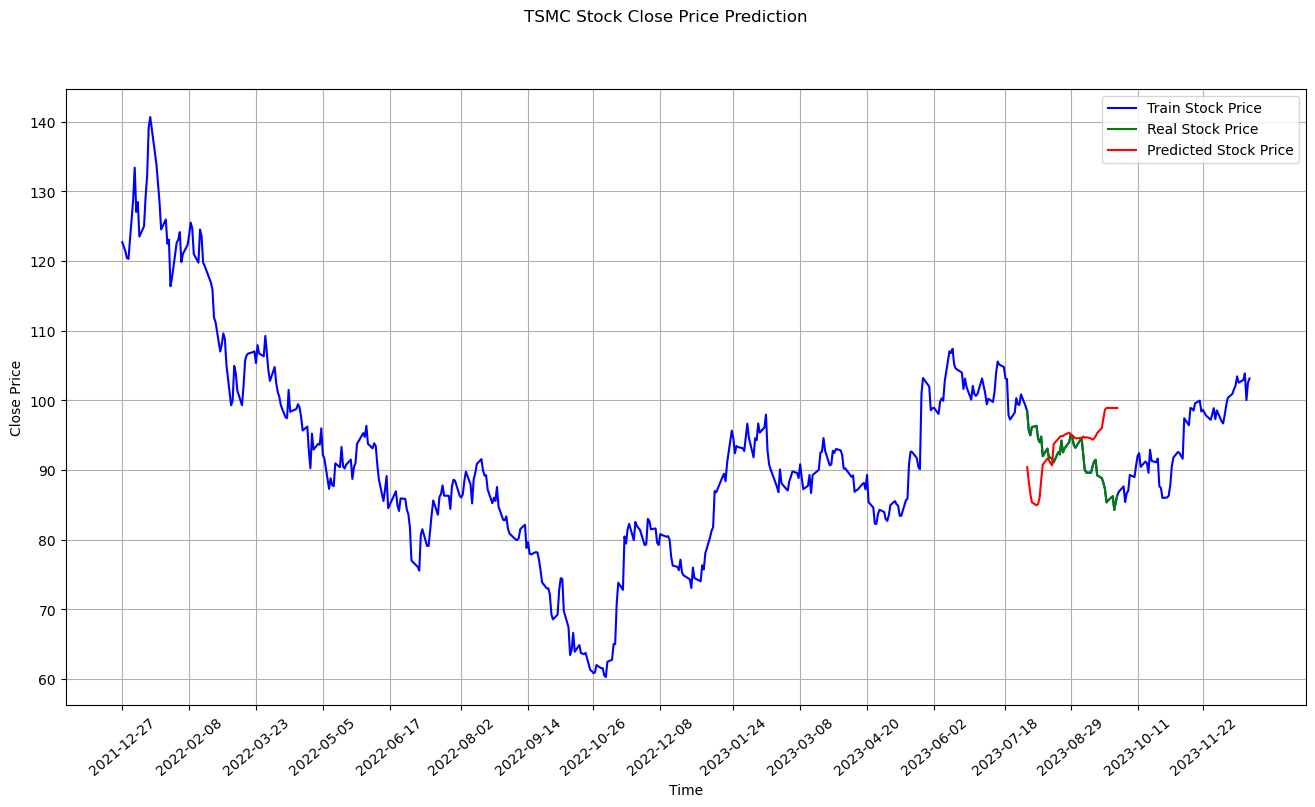

In [58]:
# Visulize the Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_test[:,0].tolist(), color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()